In [23]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import os
import scipy

file_path = "C:/Users/Shirik/Dropbox (Weizmann Institute)/Shiri/Courses/AMLLS/Project/Dataset/diabetes+130-us+hospitals+for+years+1999-2008/"
os.chdir(file_path)
os.getcwd()

full_data_file_name = "diabetic_data.csv"
training_file_name = "train_cohort.csv"
training_df = pd.read_csv(file_path+training_file_name)
print(training_df.info())

# Check the data types of the DataFrame after conversion
print(training_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30420 entries, 0 to 30419
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                30420 non-null  int64 
 1   encounter_id              30420 non-null  int64 
 2   patient_nbr               30420 non-null  int64 
 3   race                      30420 non-null  object
 4   gender                    30420 non-null  object
 5   age                       30420 non-null  object
 6   weight                    30420 non-null  object
 7   admission_type_id         30420 non-null  int64 
 8   discharge_disposition_id  30420 non-null  int64 
 9   admission_source_id       30420 non-null  int64 
 10  time_in_hospital          30420 non-null  int64 
 11  payer_code                30420 non-null  object
 12  medical_specialty         30420 non-null  object
 13  num_lab_procedures        30420 non-null  int64 
 14  num_procedures        

In [24]:
### There are 3 readmission categorical features that contain digits which is not informative and problematic for EDA purposes

#Make sure the mapping file is in the current dir
#print(os.listdir())

#Read readmission mapping file
mapping_df = pd.read_csv("IDS_mapping.csv",header=None)
#print(mapping_df.head())
original_shape_num_rows = mapping_df.shape[0]

#Remove empty rows
mapping_df = mapping_df.dropna(how='all', inplace=False) #removes 2 gap rows

#Fill empty desctioption cells with NaNs they were previously NULL
mapping_df = mapping_df.fillna(value='NaN', inplace=False)
print("Does the new mapping_df has less rows than the original? ",mapping_df.shape[0]< original_shape_num_rows) #QC

#Reset indices
mapping_df = mapping_df.reset_index(drop=True)

Does the new mapping_df has less rows than the original?  True


In [31]:
### Rearrange IDS_mapping table by storing each categorical column with its description in a df inside a dictionary
#Find rows containing the string "id" in any column
id_rows = mapping_df[mapping_df.apply(lambda row: row.astype(str).str.contains('_id', case=False)).any(axis=1)]
#print(id_rows)
id_names = list(id_rows[0])
#print(mapping_df.iloc[9])

# Extract the index of the id rows
id_rows_indices = list(id_rows.index)

#print(id_rows_indices)

# Create a dictionary with the 3 mapping dataframes
mapping_dictionary = {}

#Iterate over id_names to create subsets of mapping_df
for id_i in range(0,len(id_rows_indices)-1):
    start_index = id_rows_indices[id_i]
    end_index = id_rows_indices[id_i+1]
    #print(start_index,end_index)
    
    # Extract the subset DataFrame
    current_id_df = mapping_df.iloc[start_index:end_index]  #+1 Include end_index
    #print(current_id_df)
                 
    #Assign the values of the first row as column names
    current_id_df.columns = current_id_df.iloc[0]
    #print(current_id_df.columns)

    # Drop the first row after using it as column names
    current_id_df = current_id_df[1:].reset_index(drop=True)

    # Assign the subset DataFrame to the corresponding key in the dictionary
    mapping_dictionary[id_names[id_i]] = current_id_df
    
# Add the last subset DataFrame explicitly
last_start_index = id_rows_indices[-1]
last_id_df = mapping_df.iloc[last_start_index:]
last_id_df.columns = last_id_df.iloc[0]
last_id_df = last_id_df[1:].reset_index(drop=True)
mapping_dictionary[id_names[-1]] = last_id_df

print("The dictionary contains",len(mapping_dictionary.items()), "items")

#View dictionary dfs
for key, df in mapping_dictionary.items():
    print(f"Head of DataFrame {key}:")
    print(df.head())
    print()

The dictionary contains 3 items
Head of DataFrame admission_type_id:
0 admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available

Head of DataFrame discharge_disposition_id:
9 discharge_disposition_id                                        description
0                        1                                 Discharged to home
1                        2  Discharged/transferred to another short term h...
2                        3                      Discharged/transferred to SNF
3                        4                      Discharged/transferred to ICF
4                        5  Discharged/transferred to another type of inpa...

Head of DataFrame admission_source_id:
40 admission_source_id                                      description
0                    1                               Physician Referral
1                    2  

In [32]:
### Replace the values in the training df with the values in the dictionary
#Avoid overight of the trining df (optional)
training_df_new = training_df.copy()
#print(training_df_new.head())
training_df_new[id_names] = training_df_new[id_names].astype('str')

# Check that the columns in the DataFrame appear in the list
matching_columns = [col for col in training_df_new.columns if col in id_names]
matching_columns == id_names #QC

#Define these columns as str
training_df_new[training_df_new.columns]

# Iterate over rows in training_df_new
for id_i in id_names:
#Extract the df in mapping_dictionary for the the id_column in training_df_new
    current_dict_df = mapping_dictionary[id_i]
    #Merge the discionary columns with the training_df_new
    training_df_new = training_df_new.merge(current_dict_df,on = id_i, how ='left',suffixes=['_left','_right'])

#Rename the new columns - last 3 columns in the df
new_column_names = [element[:-3] + "_descriptor" if element.endswith("_id") else element for element in id_names]

# Create a mapping dictionary for renaming
rename_dict = dict(zip(training_df_new.columns[-3:], new_column_names))
training_df_new = training_df_new.rename(columns=rename_dict)
print(training_df_new.iloc[:,-3:])

      admission_type_descriptor  \
0                           NaN   
1                     Emergency   
2                     Emergency   
3                     Emergency   
4                     Emergency   
...                         ...   
30415                 Emergency   
30416                  Elective   
30417                  Elective   
30418                 Emergency   
30419                 Emergency   

                        discharge_disposition_descriptor  \
0                                             Not Mapped   
1                                     Discharged to home   
2                                     Discharged to home   
3                                     Discharged to home   
4                                     Discharged to home   
...                                                  ...   
30415                      Discharged/transferred to ICF   
30416  Discharged/transferred to home with home healt...   
30417                                 D

In [33]:
#Change '?' to NaNa in the medical_specialty feature
columns_to_clean = ['race','medical_specialty']  # Specify the column to clean
training_df_new[columns_to_clean] = training_df_new[columns_to_clean].replace('?', np.NaN)

# EDA
## Categorical features

In [34]:
# #Filter the training set to diabetes patients only - SKIP, Yael incorporated this already 
# diagnosis_cols_list = ['diag_' + str(num) for num in [1,2,3]]

# # Regex pattern to locate diabeteic pateints 
# pattern = r'250(\.\d{2})?'

# # count diabetes diagnosis appearance  in all 3 daignosis columns 
# diag_count = training_df_new[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)

# diabetic_only_df = training_df_new[diag_count > 0]

# print("The number of rowd left:",diabetic_only_df.shape[0])

In [161]:
#Focus on the categorical features only
#print(training_df_new.info())

all_columns = training_df_new.columns

#Subset all categorical
categorical = ['race', 'gender', 'age','medical_specialty','max_glu_serum', \
'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride', \
'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose', \
'miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin',\
'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change','diabetesMed',\
'admission_type_descriptor', 'discharge_disposition_descriptor','admission_source_descriptor']

#Subset depografics
demographics = ['race', 'gender', 'age']

#Subset medications
medications = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride', \
'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose', \
'miglitol','troglitazone','tolazamide','examide','citoglipton','glyburide-metformin',\
'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

training_df_new_categorical = training_df_new[categorical].astype('category')
print(training_df_new_categorical.shape)

22
(30420, 34)


gender
Female    16414
Male      14006
Name: count, dtype: int64
Female 53.96 %
Male: 46.04 %
race
Caucasian          21401
AfricanAmerican     6819
Hispanic             761
Other                521
Asian                197
Name: count, dtype: int64
The most frequent age category is:  [60-70)


C:\Users\Shirik\AppData\Local\Temp\ipykernel_40516\2530625548.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  female_percent = 100*gender_counts[0]/len(training_df_new)
C:\Users\Shirik\AppData\Local\Temp\ipykernel_40516\2530625548.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  male_percent = 100*gender_counts[1]/len(training_df_new)
C:\Users\Shirik\AppData\Local\Temp\ipykernel_40516\2530625548.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=trainin

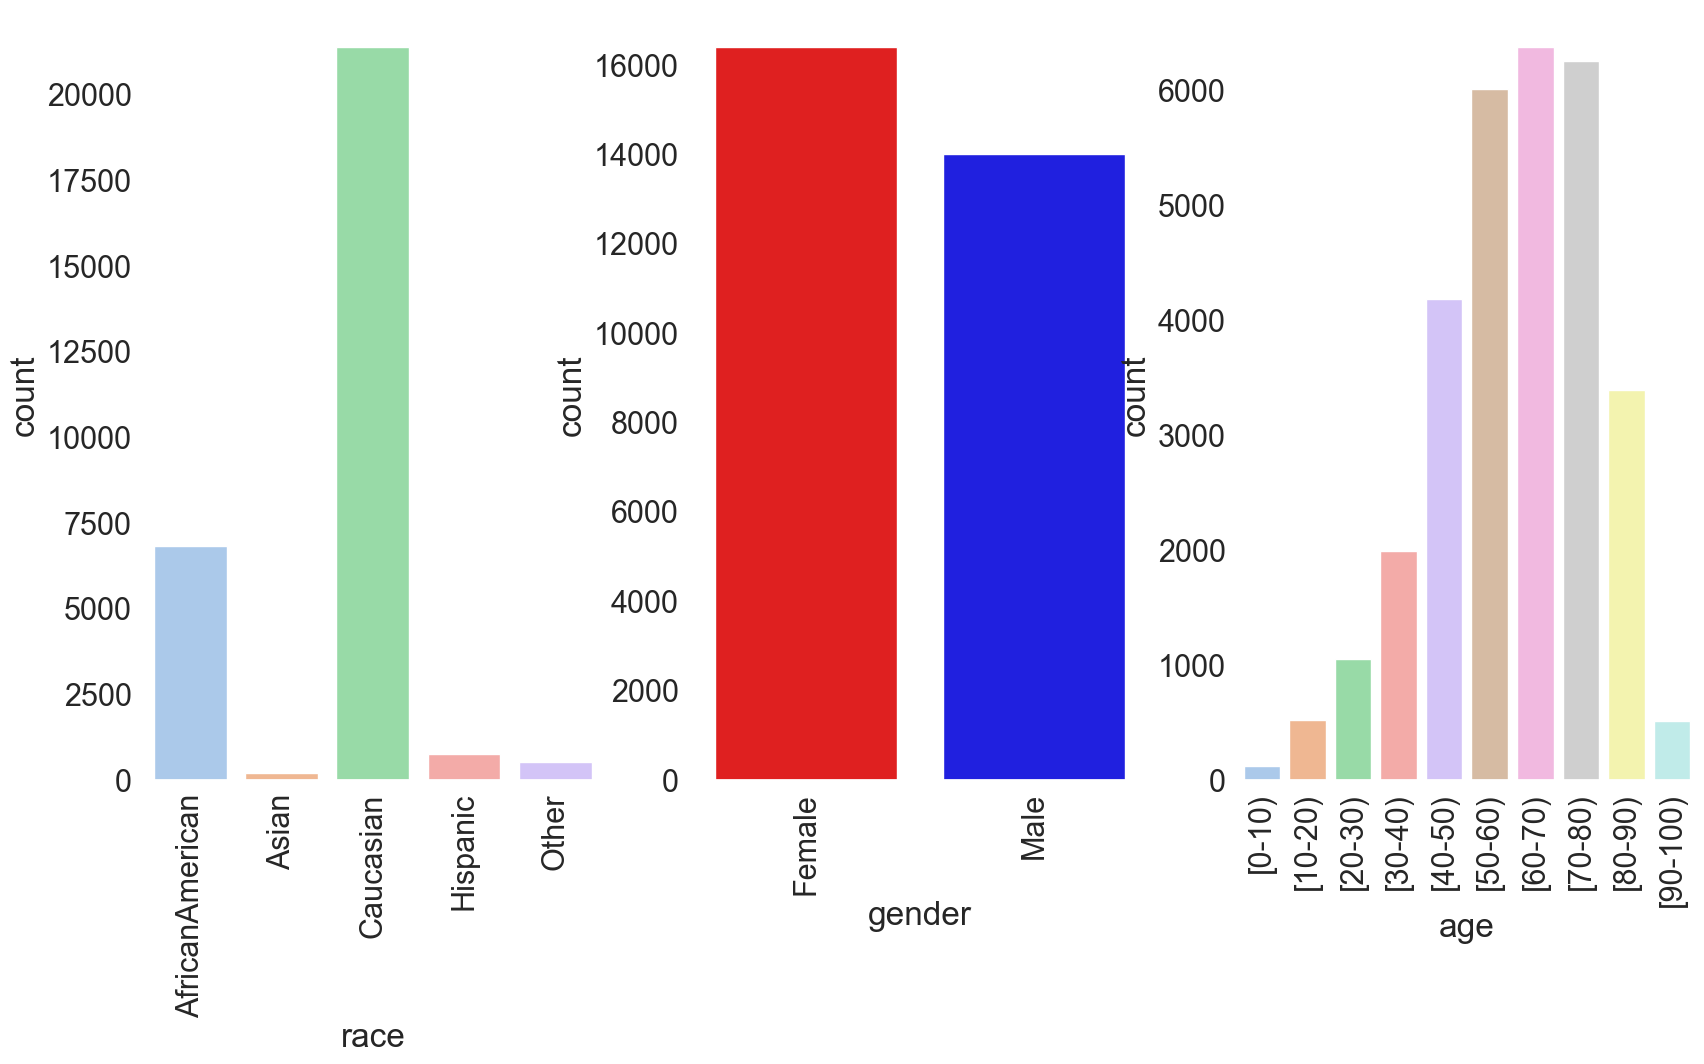

In [134]:
#Demographics: Race, gender and age
#Extracrt specific count values
#Gender
gender_counts = training_df_new_categorical['gender'].value_counts()
print(gender_counts)
female_percent = 100*gender_counts[0]/len(training_df_new)
print("Female",round(female_percent,2),"%")
male_percent = 100*gender_counts[1]/len(training_df_new)
print("Male:",round(male_percent,2),"%")
female_percent + male_percent < 100 #QC

#Race
race_counts = training_df_new_categorical['race'].value_counts().sort_values(ascending=False)
print(race_counts)

#Age
import statistics
print("The most frequent age category is: ", statistics.mode(training_df_new_categorical['age']))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=2)
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

for variable, subplot in zip(demographics, ax.flatten()):
    if variable == 'gender':
        palette = ['red', 'blue']
    else:
        palette = 'pastel'
        
    sns.countplot(data=training_df_new_categorical, x=variable, palette=palette, ax=subplot)
    
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

plt.show()

#Insights:
1. The most abundunt race is Caucasian followed by AfricanAmerican
2. There are slightly more females in the data compared to males, 53.96 and 49.06%, respectiely.
3. The mode range of ages is 60-70 (ref- introduction)

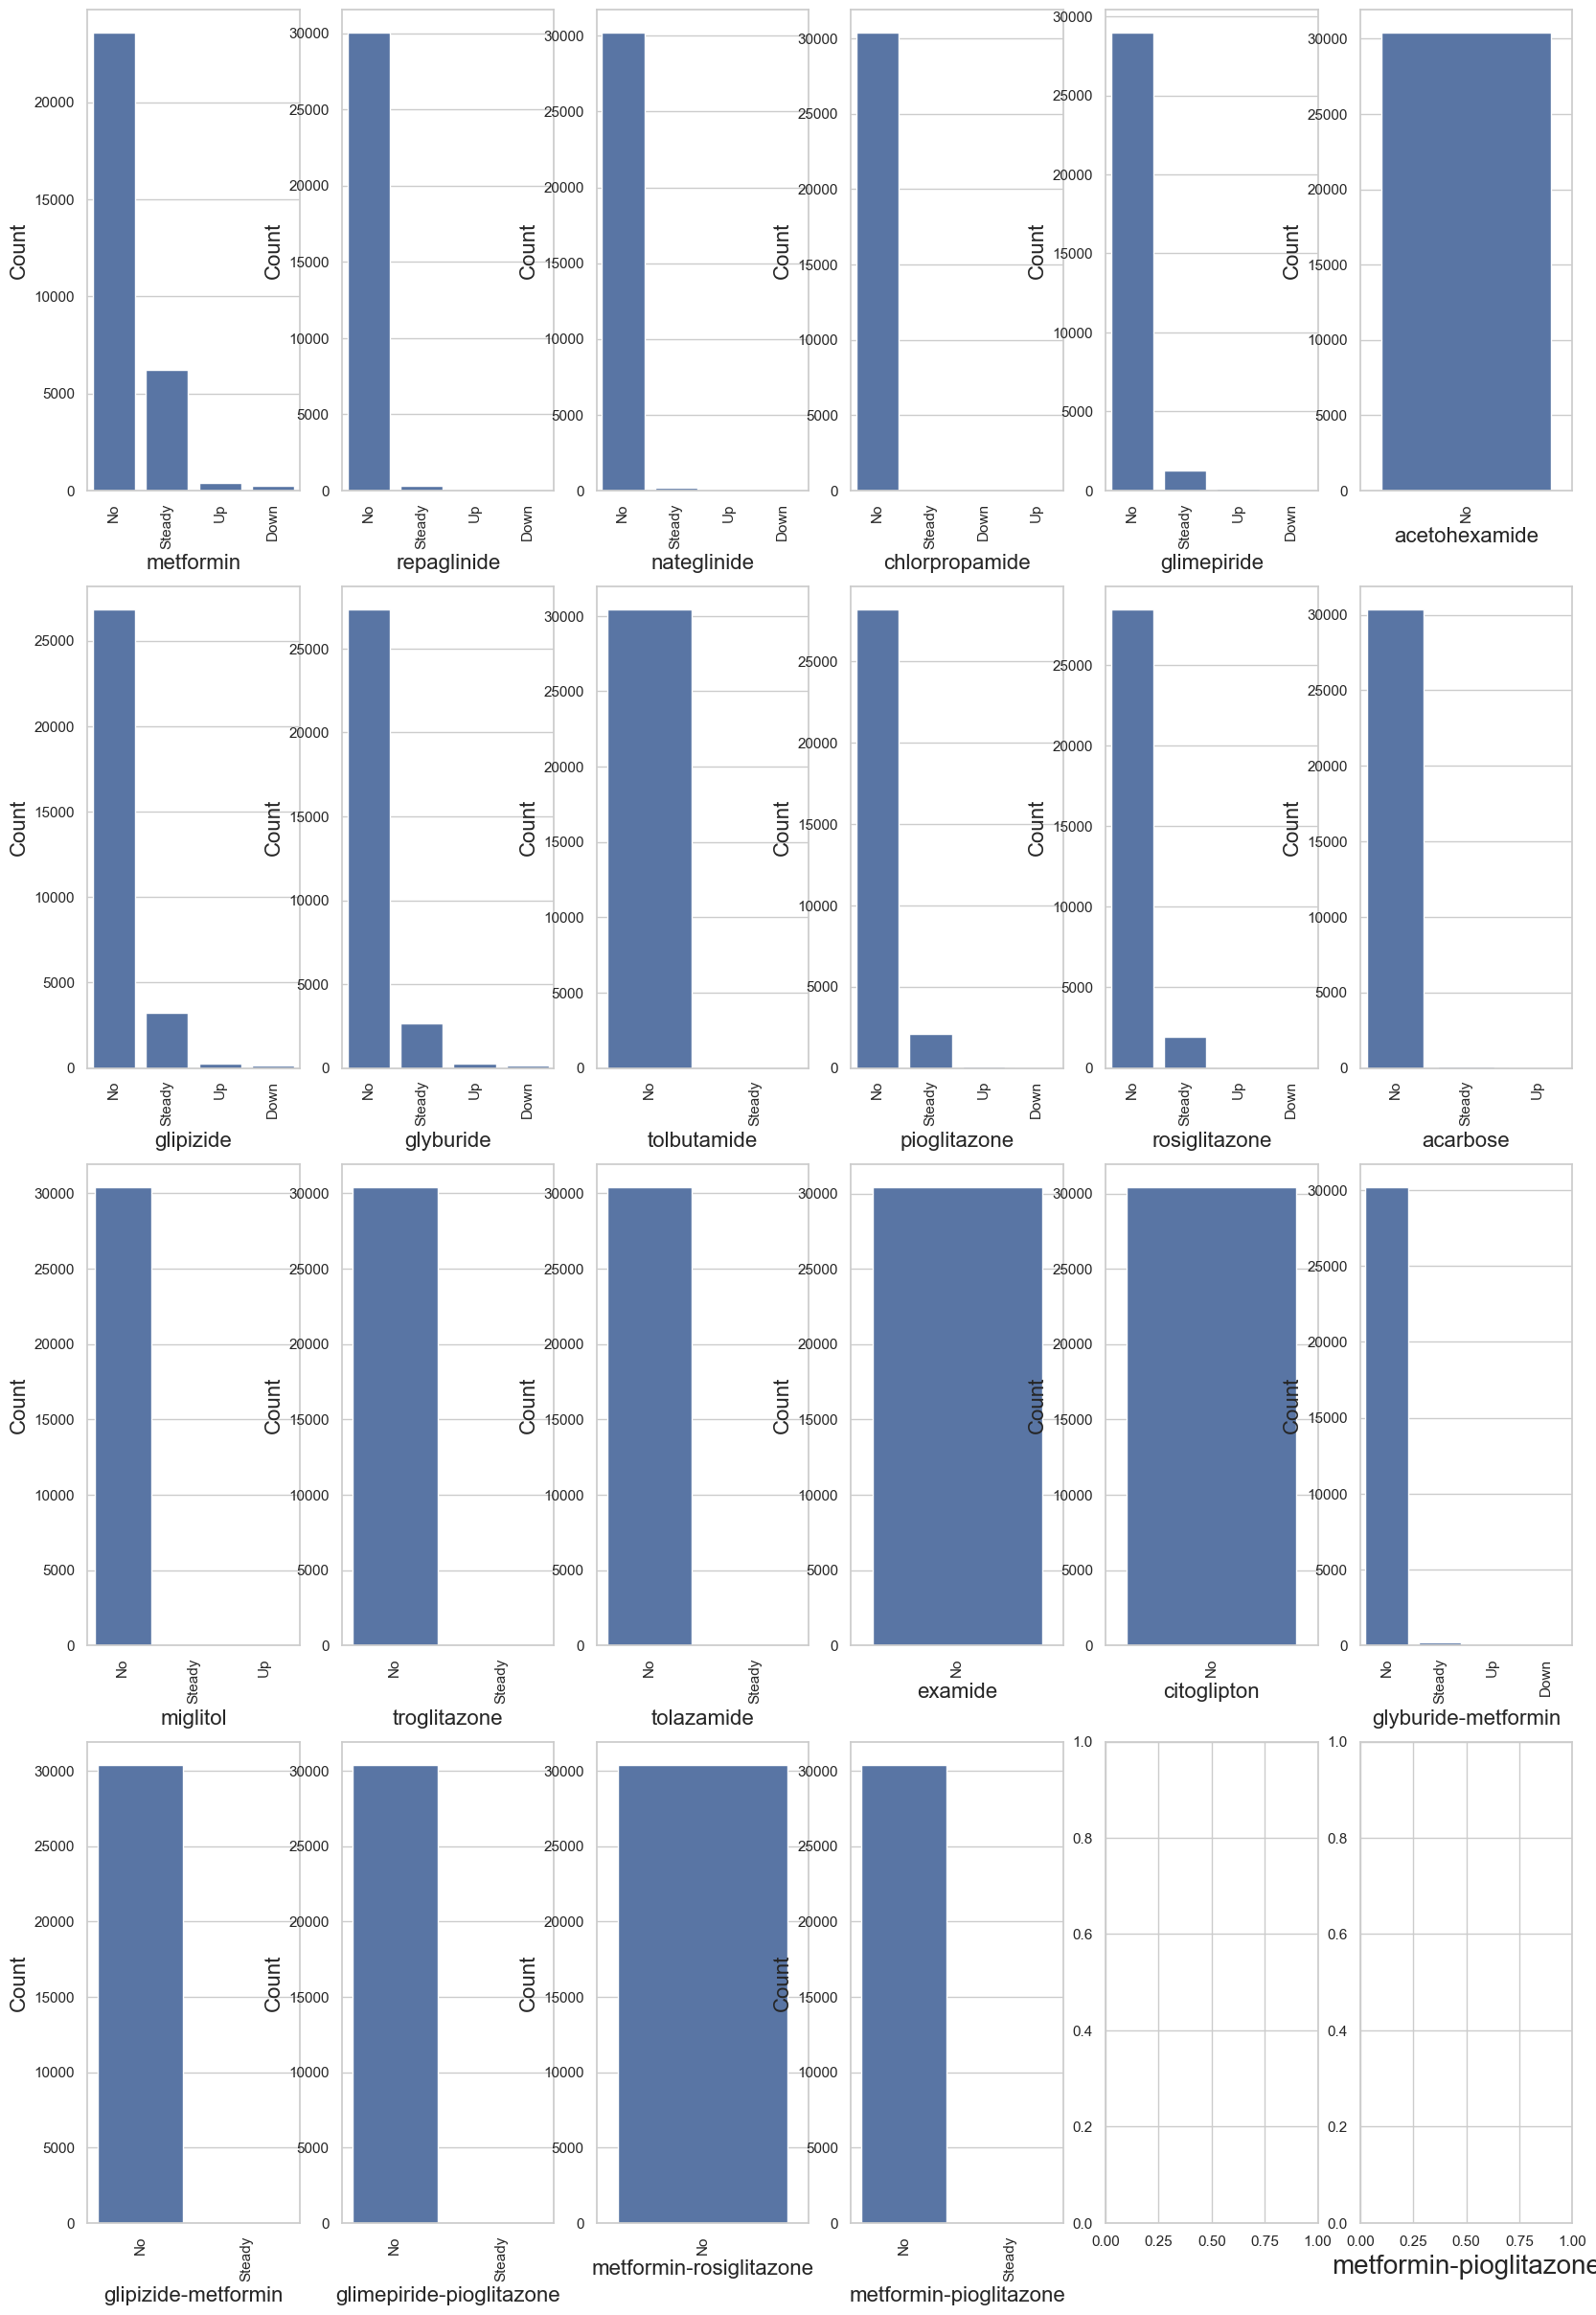

In [159]:
#Medications
sns.set_context("notebook") #talk, poster, paper
sns.set_style("whitegrid")
fig, ax = plt.subplots(4, 6, figsize=(20, 30))
for variable, subplot in zip(medications, ax.flatten()):
    sns.countplot(data = training_df_new_categorical,x = variable,\
                  order=training_df_new_categorical[variable].value_counts().index, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        plt.xlabel(variable, fontsize=20)
        subplot.set_xlabel(variable, fontsize=16)
        subplot.set_ylabel('Count', fontsize=16)

# plt.xlabel('X Label', fontsize=16)
# plt.ylabel('Y Label', fontsize=16)

# # sns.set_context("notebook")  # talk, poster, paper
# # sns.set_style("whitegrid")

# # # Filter out medications where all values are 'No'
# # filtered_medications = [medication for medication in medications if not all(training_df_new_categorical[medication] == 'No')]

# fig, ax = plt.subplots(3, 6, figsize=(20, 25))

# for variable, subplot in zip(filtered_medications, ax.flatten()):
#     data_filtered = training_df_new_categorical[training_df_new_categorical[variable] != "No"]
#     sns.countplot(data=data_filtered, x=variable,
#                   order=data_filtered[variable].value_counts().index, ax=subplot)
#     for label in subplot.get_xticklabels():
#         label.set_rotation(90)
#         plt.xlabel(variable, fontsize=20)
#         subplot.set_xlabel(variable, fontsize=16)
#         subplot.set_ylabel('Count', fontsize=16)
# plt.show()

The medications: examide, citoglipton have 'No' in the full data and obviously in the training set as well.
In addition, Acetohexamide and the combination of metformin-rosiglitasone have only 'No'in the training set.

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'weight', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_descriptor', 'discharge_disposition_descriptor',
      

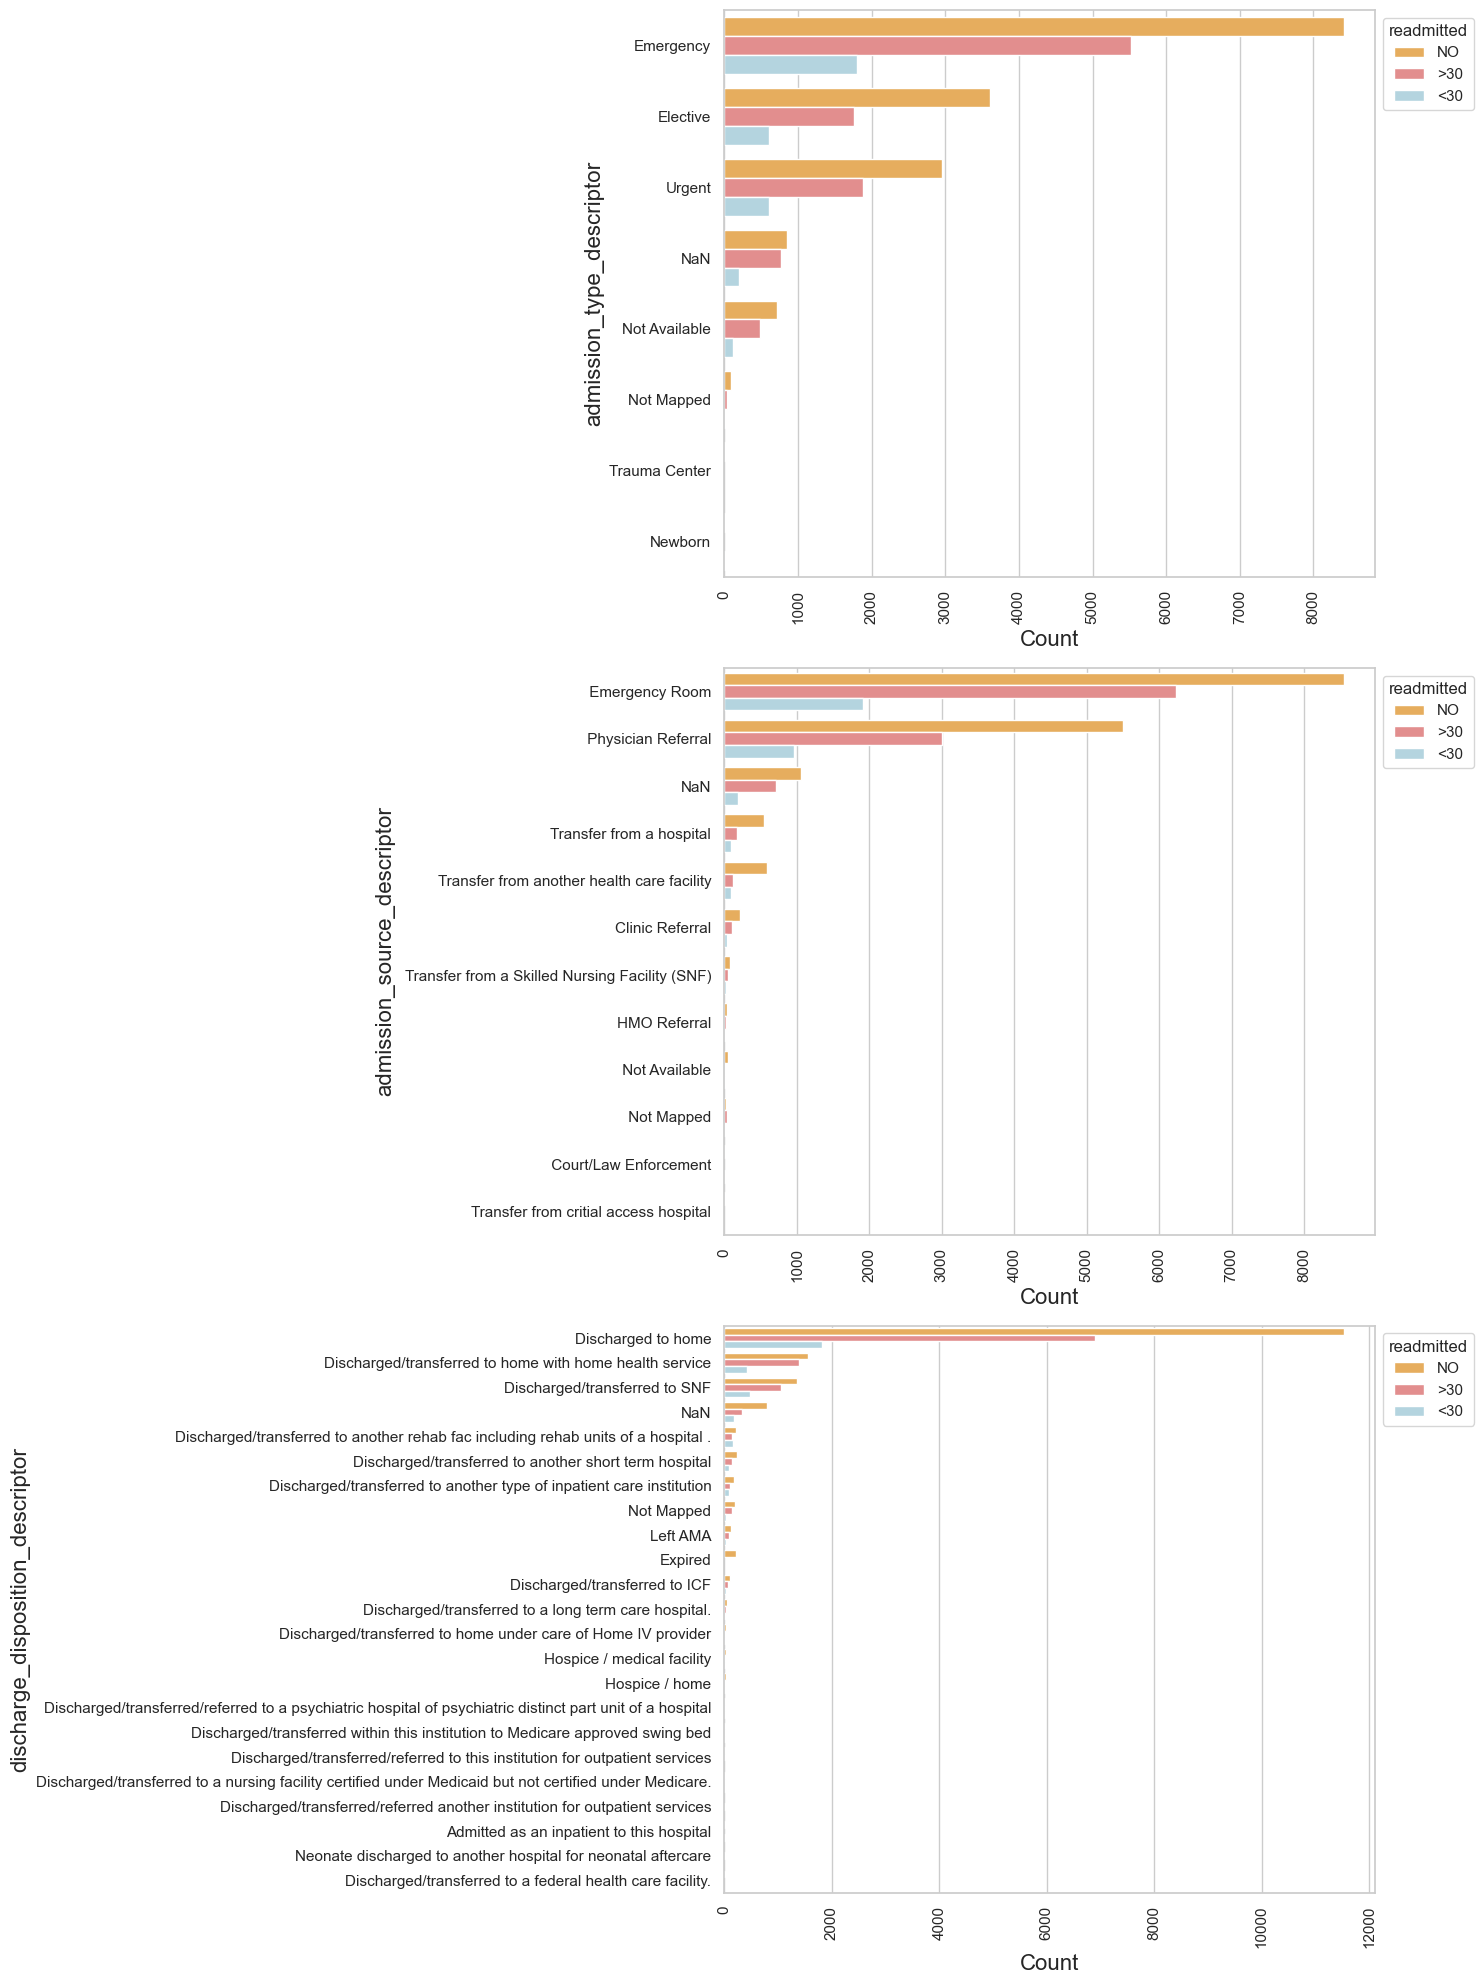

In [181]:
# discharge_disposition_descriptor/admission_type_descriptor/admission_source_descriptor
readmission_discharge = ['admission_type_descriptor','admission_source_descriptor','discharge_disposition_descriptor']
sns.set_context("poster") #talk, poster, paper
sns.set_theme(style="whitegrid")

sns.set_color_codes("pastel")
print(training_df_new.columns)

fig, ax = plt.subplots(3, 1, figsize=(15, 20))

for variable, subplot in zip(readmission_discharge, ax.flatten()):
    ax = sns.countplot(data=training_df_new, y=variable,
                  order=training_df_new[variable].value_counts().index,
                  hue='readmitted',
                  palette=['#fdb147', 'lightcoral', 'lightblue'], ax=subplot)
    
    total_counts = len(training_df_new)  # Total number of observations
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    # for p in subplot.patches:
    #     # Calculate the percentage of each count observation normalized by readmission
    #     percentage = '{:.1f}%'.format(100 * p.get_width() / total_counts)
    #     x = p.get_x() + p.get_width() + 0.02
    #     y = p.get_y() + p.get_height() / 2
    #     subplot.annotate(percentage, (x, y), fontsize=10)

    for label in subplot.get_xticklabels():
        label.set_rotation(90)

    # Increase font size of x and y labels
    subplot.set_xlabel('Count', fontsize=16)
    subplot.set_ylabel(variable, fontsize=16)

plt.tight_layout()
plt.show()


1) Most of the admission types are Emergency with the emergency room being the most frequent admission source which makes a lot of sense

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'weight', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_descriptor', 'discharge_disposition_descriptor',
      

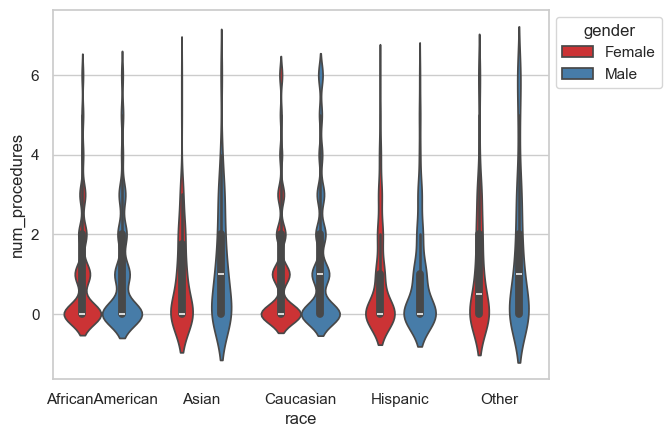

In [39]:
#Boxplots
print(training_df_new.columns)
ax = sns.violinplot(x=training_df_new_categorical['race'], y=training_df_new['num_procedures'],\
            hue= training_df_new_categorical["gender"], palette= "Set1")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

The top 5 medical_specialties are: col_0                   count
medical_specialty            
InternalMedicine         4946
Family/GeneralPractice   2491
Emergency/Trauma         2045
Cardiology               1363
Surgery-General          1071
readmitted
<30    1263
>30    4096
NO     6557
Name: medical_specialty, dtype: int64


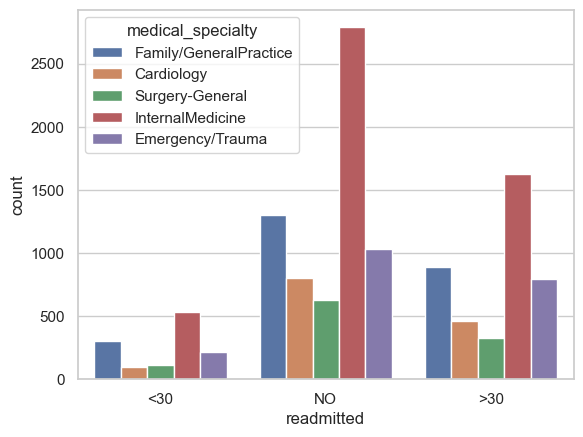

   readmitted       medical_specialty  count  percentage
0         <30              Cardiology     98    7.759303
1         <30        Emergency/Trauma    219   17.339667
2         <30  Family/GeneralPractice    303   23.990499
3         <30        InternalMedicine    530   41.963579
4         <30         Surgery-General    113    8.946952
5         >30              Cardiology    461   11.254883
6         >30        Emergency/Trauma    792   19.335938
7         >30  Family/GeneralPractice    886   21.630859
8         >30        InternalMedicine   1628   39.746094
9         >30         Surgery-General    329    8.032227
10         NO              Cardiology    804   12.261705
11         NO        Emergency/Trauma   1034   15.769407
12         NO  Family/GeneralPractice   1302   19.856642
13         NO        InternalMedicine   2788   42.519445
14         NO         Surgery-General    629    9.592802


In [255]:
#Mediacl Specialty
count_medical_specialty = pd.crosstab(index=training_df_new['medical_specialty'], columns='count').sort_index(axis=0, ascending=False)
count_medical_specialty_sorted = count_medical_specialty.sort_values('count', ascending=False)
n = 5

print('The top',n,"medical_specialties are:", count_medical_specialty_sorted[:n] )

# Select the top n medical specialties
top_medical_specialties = count_medical_specialty_sorted[:n].index.tolist()
#print(top_medical_specialties)

# Filter the DataFrame to include only the top medical specialties
filtered_df = training_df_new[training_df_new['medical_specialty'].isin(top_medical_specialties)]

# Create the countplot with percentages
# ax = sns.countplot(data=filtered_df, x="readmitted", hue="medical_specialty", dodge=True)

# # Calculate percentages
# total_counts = filtered_df.groupby('readmitted').size()
# print(total_counts)
# for p in ax.patches:
#     height = p.get_height()
#     hue = p.get_facecolor() # Get the color of the bar
#     hue_idx = ax.patches.index(p) % len(total_counts)  # Index within the hue list
#     specialty = list(total_counts.index)[hue_idx]  # Extract the corresponding medical specialty
#     total = total_counts[specialty]
#     ax.text(p.get_x() + p.get_width() / 2.,
#             height + 3,
#             '{:.1f}%'.format(100*height / total),
#             ha="center")
# Calculate percentages

total_per_readmitted = filtered_df.groupby('readmitted')['medical_specialty'].count()
total_per_specialty = filtered_df.groupby('medical_specialty')['readmitted'].count()

print(total_per_readmitted)
# Plot
ax = sns.countplot(data=filtered_df, x="readmitted", hue="medical_specialty", dodge=True)
plt.show()

# Group by 'readmitted' and 'medical_specialty', and count occurrences
grouped = filtered_df.groupby(['readmitted', 'medical_specialty']).size().reset_index(name='count')

# Calculate the total count for each 'readmitted' category
total_per_readmitted = grouped.groupby('readmitted')['count'].sum()

# Calculate percentages
grouped['percentage'] = grouped.apply(lambda row: (row['count'] / total_per_readmitted[row['readmitted']]) * 100, axis=1)

print(grouped)

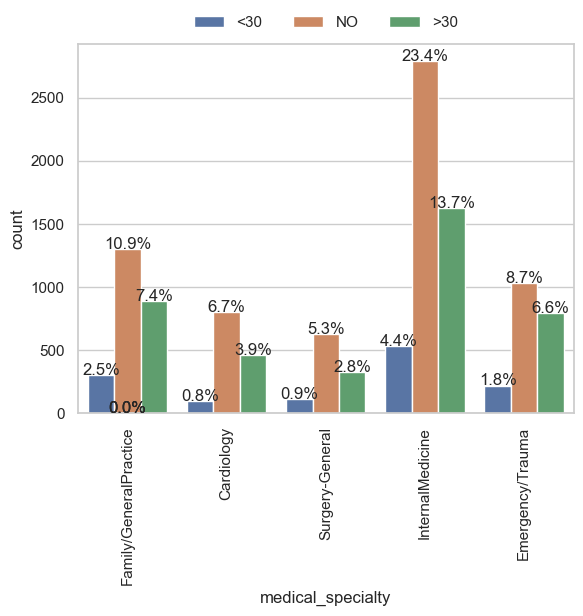

In [257]:
# Count the occurrences of each medical specialty
count_medical_specialty = pd.crosstab(index=training_df_new['medical_specialty'], columns='count').sort_index(axis=0, ascending=False)
count_medical_specialty_sorted = count_medical_specialty.sort_values('count', ascending=False)

# Select the top n medical specialties
n = 5
top_medical_specialties = count_medical_specialty_sorted[:n].index.tolist()

# Filter the DataFrame to include only the top medical specialties
filtered_df = training_df_new[training_df_new['medical_specialty'].isin(top_medical_specialties)]

# Create the countplot with percentages
ax = sns.countplot(data=filtered_df, x="medical_specialty", hue="readmitted", dodge=True)

# Calculate percentages based on the total count of observations in each medical specialty category
total_counts = filtered_df.groupby('readmitted').size()
total_counts_sum = total_counts.sum()
for p in ax.patches:
    height = p.get_height()
    hue = p.get_facecolor()  # Get the color of the bar
    hue_idx = ax.patches.index(p) % len(total_counts)  # Index within the hue list
    specialty = list(total_counts.index)[hue_idx]  # Extract the corresponding medical specialty
    total = total_counts[specialty]
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.1f}%'.format(height / total_counts_sum * 100),
            ha="center")

# Move the legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, title=None, frameon=False)

ax.tick_params(axis='x', rotation=90)
plt.show()


In [ ]:
#Plot the label Frwq by medical specialty
specialty_plot = sns.FacetGrid(data=training_df_new,\
                               col='medical_specialty',palette='Set1', hue="readmitted", col_wrap=6)
specialty_plot.map(sns.histplot,"gender",binwidth=2)
specialty_plot.add_legend()

specialty_plot.set_axis_labels("Label", "Freq")

# Adjust y-axis range dynamically for each subplot
# for ax, specialty in zip(specialty_plot.axes.flat, training_df_new['medical_specialty'].unique()):
#     specialty_data = training_df_new[training_df_new['medical_specialty'] == specialty]
#     readmission_counts = specialty_data['readmitted'].value_counts()
#     max_count = specialty_data.groupby('gender')['readmitted'].count().max()
#     if max_count is not None and not np.isnan(max_count) and not np.isinf(max_count):
#         ax.set_ylim(0, max_count)  # Set y-axis range based on the maximum count of readmissions in the data for the current specialty
#     else:
#         ax.set_ylim(0, 1500)  # Set a default y-axis range if maximum count is NaN or infinite

# Adjust layout
specialty_plot.tight_layout()

count    30420.000000
mean         3.936292
std          2.788338
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         14.000000
Name: time_in_hospital, dtype: float64
count    30420.000000
mean        41.542834
std         19.388947
min          1.000000
25%         30.000000
50%         43.000000
75%         55.000000
max        118.000000
Name: num_lab_procedures, dtype: float64


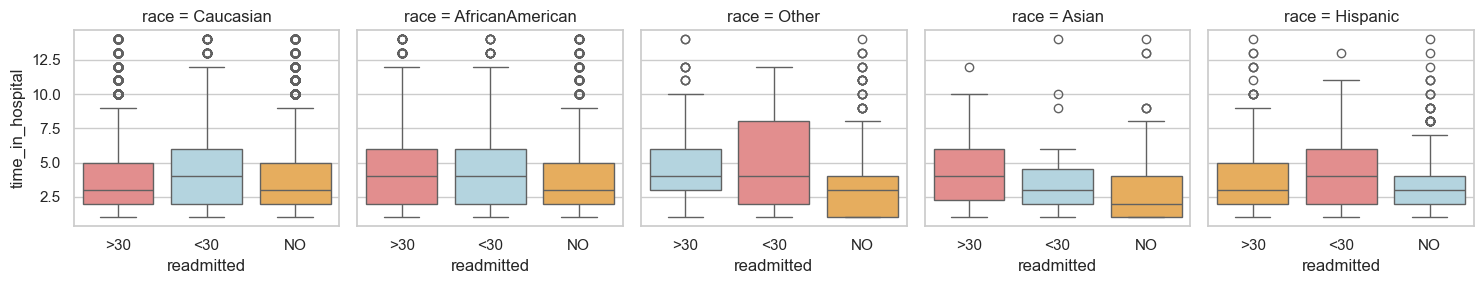

In [190]:
#Does longer time in the hospital lead to lower readmittion?
print(training_df_new['time_in_hospital'].describe())
print(training_df_new['num_lab_procedures'].describe())
order=[">30","<30","NO"]

g = sns.FacetGrid(training_df_new, col="race", margin_titles=True, despine=False)
g.map_dataframe(sns.boxplot, x="readmitted", y="time_in_hospital" ,hue = "readmitted",palette = ['#fdb147', 'lightcoral', 'lightblue'], order = order)
 #'num_lab_procedures', 'num_procedures
    

readmitted
<30    1.0
>30    0.0
NO     1.0
Name: num_procedures, dtype: float64


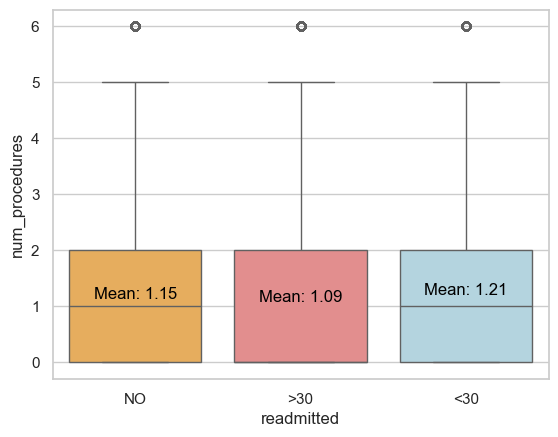

In [207]:
#Does more lab proceedure lead to lower readmittion?

# Create the boxplot
sns.boxplot(data=training_df_new, x="readmitted", y="num_procedures", hue="readmitted", palette=['#fdb147', 'lightcoral', 'lightblue'])

# Calculate and add mean values
means = training_df_new.groupby("readmitted")["num_procedures"].mean()
medians = training_df_new.groupby("readmitted")["num_procedures"].median()
print(medians)

for i, mean_value in enumerate(means):
    plt.text(i, mean_value, f'Mean: {mean_value:.2f}', color='black', ha="center")


plt.show()

<Axes: xlabel='readmitted', ylabel='normalized_num_procedures'>

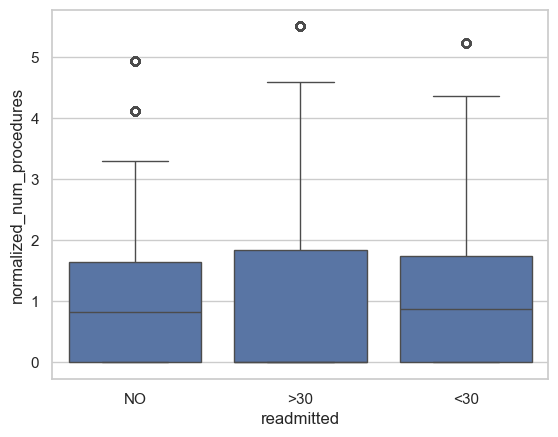

In [84]:
# Compute the mean of num_procedures for each readmitted category
mean_num_procedures = training_df_new.groupby('readmitted')['num_procedures'].mean()

# Normalize num_procedures by dividing by the mean for each readmitted category
training_df_new['normalized_num_procedures'] = training_df_new.apply(lambda row: row['num_procedures'] / mean_num_procedures[row['readmitted']], axis=1)

# Create a boxplot with normalized num_procedures
sns.boxplot(data=training_df_new, x="readmitted", y="normalized_num_procedures")

C:\Users\Shirik\AppData\Local\Temp\ipykernel_40516\4080673809.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = training_df_new,\


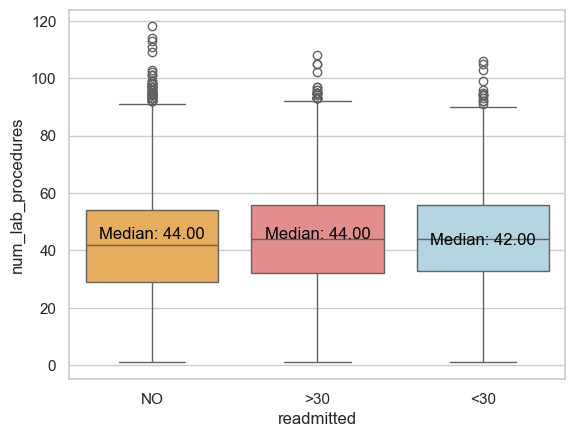

In [211]:
# Calculate and add mean values
medians = training_df_new.groupby("readmitted")["num_lab_procedures"].median()


sns.boxplot(data = training_df_new,\
            x="readmitted", y="num_lab_procedures",palette=['#fdb147', 'lightcoral', 'lightblue'])
 #'num_lab_procedures', 'num_procedures'  'num_medications'
for i, med_value in enumerate(medians):
    plt.text(i, med_value, f'Median: {med_value:.2f}', color='black', ha="center")

C:\Users\Shirik\AppData\Local\Temp\ipykernel_40516\2684371065.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=training_df_new, x="age", y="num_medications", order=sorted_age_groups, palette="pastel")


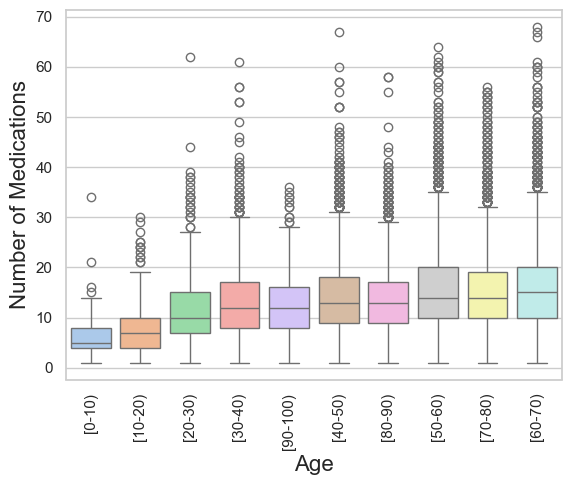

In [166]:
#Age and num_medications
# sns.boxplot(data = training_df_new,\
#             x="age", y="num_medications", palette= "pastel")
# # Rotate the x-axis labels
# plt.xticks(rotation=90)
# # Increase font size of x and y labels
# plt.xlabel("Age", fontsize=16)
# plt.ylabel("Number of Medications", fontsize=16)

# Calculate median number of medications for each age group
median_values = training_df_new.groupby("age")["num_medications"].median()
sorted_age_groups = median_values.sort_values().index

# Create the boxplot with sorted order
sns.boxplot(data=training_df_new, x="age", y="num_medications", order=sorted_age_groups, palette="pastel")

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Increase font size of x and y labels
plt.xlabel("Age", fontsize=16)
plt.ylabel("Number of Medications", fontsize=16)

plt.show()

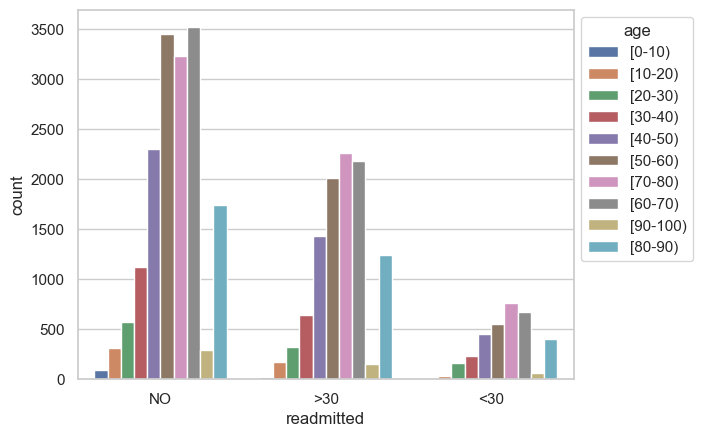

In [19]:
#Age and labels
ax = sns.countplot(data = training_df_new,\
            hue="age", x="readmitted")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

1) Age range 70-80 is the most readmitted, both >30 and <30 days.
2) 


<Axes: xlabel='num_lab_procedures', ylabel='Density'>

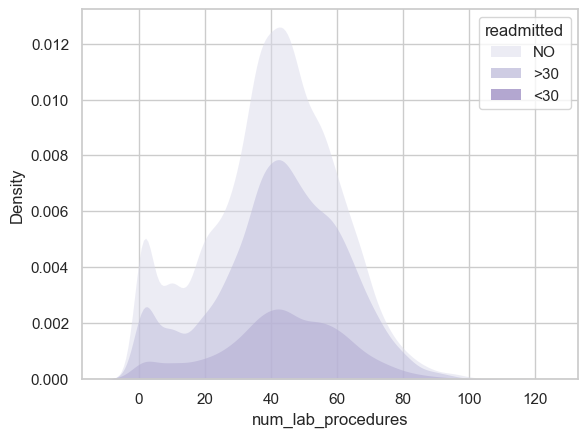

In [20]:
sns.kdeplot(data=training_df_new, x="num_lab_procedures", hue="readmitted",
    fill=True, palette="Purples",
    alpha=.5, linewidth=0)

<Axes: xlabel='readmitted', ylabel='Count'>

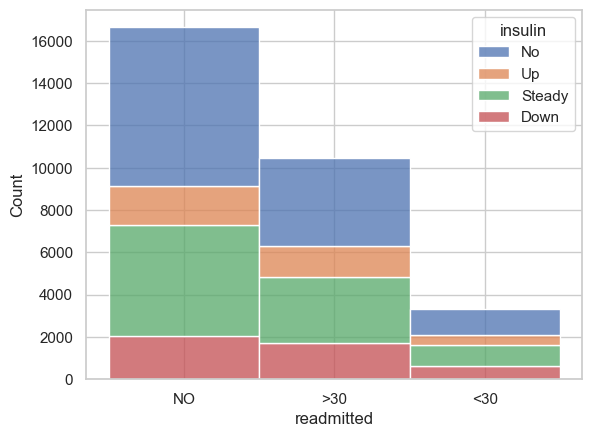

In [21]:
#Insulin status and labels
sns.histplot(data = training_df_new,\
            hue="insulin", x="readmitted",kde=False,multiple= "stack")

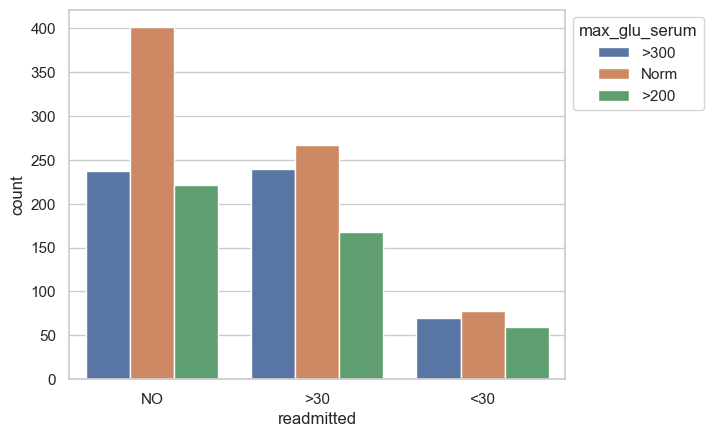

In [22]:
#Diabetes common indicators
#Labels and max_glu
ax = sns.countplot(data = training_df_new,\
            hue="max_glu_serum", x="readmitted")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

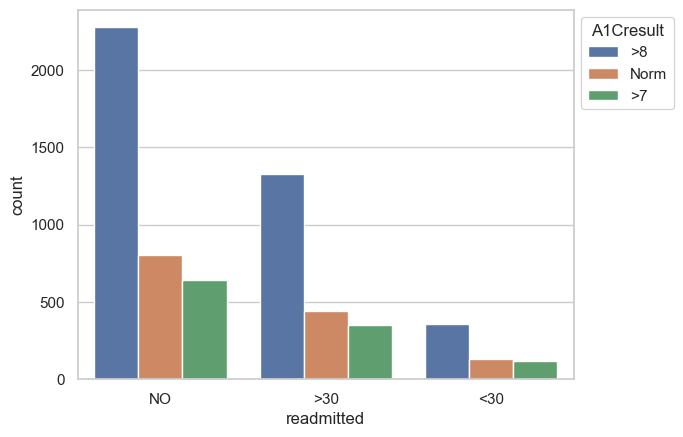

In [97]:
#Labels and max_glu
ax = sns.countplot(data = training_df_new,\
            hue="A1Cresult", x="readmitted")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))